In [117]:
import numpy as np
import random
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from skimage.transform import resize
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Activation, Dense, Input, Dropout, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
import keras.backend as K

In [122]:
## Constants
OLD_IMAGE_DIMS = (218, 178, 3)
NEW_IMAGE_DIMS = (64, 64, 3)
CROP_IMAGE_DIMS = (25, 45, 153, 173)
BATCH_SIZE = 128 # Hva er dette?
N = 6
NUM_ATTRIBUTES = 40
NUM_BATCHES = 1
LATENT_DIM = 64
TOT_IMAGES = 202599
EPOCHS = 1

In [52]:
## Constants needed to run in Google Colab
PATH = './'
IMAGES = 'img_align_celeba/'
ATTRIBUTES = 'list_attr_celeba.txt'

[array([[[[0.04705882, 0.03333334, 0.1882353 ],
         [0.04705882, 0.02745098, 0.18431373],
         [0.05098039, 0.03137255, 0.1882353 ],
         ...,
         [0.01176471, 0.02352941, 0.16078432],
         [0.01176471, 0.02352941, 0.15686275],
         [0.00980392, 0.02156863, 0.1509804 ]],

        [[0.04803922, 0.0245098 , 0.18333334],
         [0.04705882, 0.0254902 , 0.18529412],
         [0.04901961, 0.02745098, 0.19411765],
         ...,
         [0.01568628, 0.02156863, 0.16078432],
         [0.01568628, 0.02156863, 0.15882353],
         [0.01372549, 0.01960784, 0.15490197]],

        [[0.05196078, 0.02843137, 0.18921569],
         [0.05490196, 0.03333334, 0.2       ],
         [0.04607843, 0.02843137, 0.2009804 ],
         ...,
         [0.01960784, 0.01960784, 0.16078432],
         [0.01960784, 0.01960784, 0.16078432],
         [0.01764706, 0.01764706, 0.15882353]],

        ...,

        [[0.07352941, 0.0382353 , 0.25      ],
         [0.05882353, 0.02941176, 0.20686275

TypeError: Invalid shape (128, 64, 64, 3) for image data

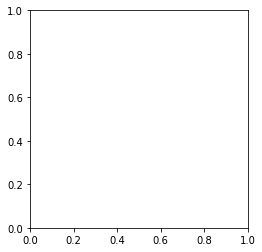

In [132]:
## Loading dataset
def get_attributes(filename):
  f = open(filename, 'r')
  lines = f.readlines()
  attributes = []
  i = 0
  for line in lines:
      if i != 0 and i != 1:
        line = line.split()
        #line.pop(0)
        attributes.append(line)
      i += 1
  return attributes

def initialize_training_set(): 
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    
    while True:
        chosen_info = random.sample(all_attributes, N)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        resized_images = []
    
        for ind in range(len(chosen_info)):
            image_path = PATH + IMAGES + chosen_images[ind]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        chosen_attributes = np.array(chosen_attributes, dtype=np.float32)

        yield [resized_images, chosen_attributes], None 
        
def initialize_test_set():
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    info_in_batches = []
    attributes_in_batches = []
    images_in_batches = []
    test_set = []
    
    for i in range(NUM_BATCHES):
        chosen_info = random.sample(all_attributes, BATCH_SIZE)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        
        info_in_batches.append(chosen_info)
        attributes_in_batches.append(chosen_attributes)
        images_in_batches.append(chosen_images)
        
    for i in range(NUM_BATCHES):
        chosen_images = images_in_batches[i]
        attributes = attributes_in_batches[i]
        resized_images = []
        
        for j in range(BATCH_SIZE):
            image_path = PATH + IMAGES + chosen_images[j]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        #print(resized_images)
        attributes = np.array(chosen_attributes, dtype=np.float32)

        #yield [resized_images, attributes], None
        test_set.append([resized_images, attributes])
    return test_set

training_set = initialize_training_set()
test_set = initialize_test_set()

i = test_set[0]
print(i)
img = i[0]
plt.imshow(img)
plt.show()

In [110]:

class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE():
  #Define encoder model.
  input_img = Input(shape = NEW_IMAGE_DIMS, name='input_img')
  labels = Input(shape = (NUM_ATTRIBUTES,), name='labels')

  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(input_img)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

  #encode = Encode_Decode(input_img) #Done

  shape_before_flattening = K.int_shape(x)[1:]
  #shape_before_flattening = K.int_shape(encode)[1:]

  x = Flatten()(x)

  z_mean = Dense(LATENT_DIM, name='z_mean')(x)
  z_log_sigma = Dense(LATENT_DIM, name='z_log_sigma')(x)
  z = Sampling()([z_mean, z_log_sigma])

  zy = Concatenate()([z, labels])

  inputs_embedding = Input(shape=(LATENT_DIM + NUM_ATTRIBUTES,))
  embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
  embedding = Reshape(shape_before_flattening)(embedding)

  #Decoding
  x_ = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(embedding)
  x_ = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
  x_ = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid')(x_)

  #x_hat = Encode_Decode(embedding)

  encoder = Model(inputs = [input_img, labels], outputs = zy, name="encoder")
  decoder = Model(inputs = inputs_embedding, outputs = x_, name="decoder")

  vae_out = decoder(encoder([input_img, labels]))

  rec_loss =  np.prod(NEW_IMAGE_DIMS) * binary_crossentropy(Flatten()(input_img), Flatten()(vae_out))
  kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
  vae_loss = K.mean(rec_loss + kl_loss)

  vae = Model(inputs = [input_img, labels], outputs = vae_out, name="vae")

  vae.add_loss(vae_loss)

  optimizer = Adam(lr=0.0005, beta_1 = 0.5)
  vae.compile(optimizer)

  return vae, encoder, decoder

vae, encoder, decoder = VAE()

encoder.summary()
decoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_660 (Conv2D)             (None, 32, 32, 32)   896         input_img[0][0]                  
__________________________________________________________________________________________________
conv2d_661 (Conv2D)             (None, 16, 16, 64)   18496       conv2d_660[0][0]                 
__________________________________________________________________________________________________
conv2d_662 (Conv2D)             (None, 8, 8, 128)    73856       conv2d_661[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [111]:
vae.fit(training_set, steps_per_epoch=TOT_IMAGES//BATCH_SIZE, verbose=1, epochs=EPOCHS)

Epoch 1/1
1582/1582 [==============================] - 466s 295ms/step - loss: 7098.4160


In [112]:
# Save model weights
vae.save_weights('./vae.h5')
decoder.save_weights('./decoder.h5')
encoder.save_weights('./encoder.h5')

In [119]:
# Calculate Frechet Inception Distance (https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/)

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


"\n# load cifar10 images\n(images1, _), (images2, _) = cifar10.load_data()\nshuffle(images1)\nimages1 = images1[:10000]\nprint('Loaded', images1.shape, images2.shape)\n\n# convert integer to floating point values\nimages1 = images1.astype('float32')\nimages2 = images2.astype('float32')\n\n# resize images\nimages1 = scale_images(images1, (299,299,3))\nimages2 = scale_images(images2, (299,299,3))\nprint('Scaled', images1.shape, images2.shape)\n# pre-process images\nimages1 = preprocess_input(images1)\nimages2 = preprocess_input(images2)\n# calculate fid\nfid = calculate_fid(model, images1, images2)\nprint('FID: %.3f' % fid)\n"

In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg')#, input_shape=(299,299,3))

In [ ]:
def make_test_dataset():
    

In [124]:
def celeba_vae_eval_generator():
  attributes = np.array(pd.read_csv(Library + Attributes_txt_file, skiprows=2, header=None, delim_whitespace=True))
  attributes = attributes[np.random.choice(attributes.shape[0], 10000, replace=False)]
  with ZipFile(Library + Celeba_Zip, 'r') as Celeba_Dataset:
    batched = 0
    while batched < 10000:
      images = attributes[batched: batched + Batch_Size]
      image_batch = []
      attributes_batch = []
      for image_info in images:
        image = cv2.imdecode(np.frombuffer(Celeba_Dataset.read(Celeba_images + image_info[0]), np.uint8), cv2.IMREAD_COLOR)[...,::-1] / 255.0
        image = image [45:173 , 25:153]
        image = cv2.resize(src=image, dsize=(Image_Dim_Crop[0], Image_Dim_Crop[1]))
        image_batch += [image]
        attributes_batch += [image_info[1:]]
      image_batch = np.array(image_batch, dtype=np.float32)
      attribute_batch = np.array(attributes_batch, dtype=np.int32)

      batched += Batch_Size

      yield [image_batch, attribute_batch]

#validation_dataset = celeba_vae_eval_generator()
print(validation_dataset)
validation_dataset = test_set

print(test_set)

[[array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.       

In [ ]:
print("Calculating activations for each batch...")
for batch in test_set:
    


In [125]:
print("Calculating activations for each batch...")
img_act = np.array([]).reshape((0, 2048))
pred_act = np.array([]).reshape((0, 2048))
i = 1
for batch in validation_dataset:
    images = batch[0]
    print("Batch", i, "- Num. samples:", images.shape[0])
    predictions = vae.predict(batch)
    print('1')
    if i == 1:
        imgs1 = images
        prediction1 = predictions
    images = images * 255.0
    predictions = predictions * 255.0
    images1 = scale_images(images, (299, 299, 3))
    print('2')
    images1 = preprocess_input(images1)
    images2 = scale_images(predictions, (299, 299, 3))
    print('3')
    images2 = preprocess_input(images2)
    a = inception_model.predict(images1)
    print('4')
    b = inception_model.predict(images2)
    img_act = np.concatenate((img_act, a), axis = 0)
    print('5')
    pred_act = np.concatenate((pred_act, b), axis = 0)
    i += 1
print("Done!")
#show_batch(imgs1)
#show_batch(prediction1)

Calculating activations for each batch...
Batch 1 - Num. samples: 128
1
2
3
4
5
Done!


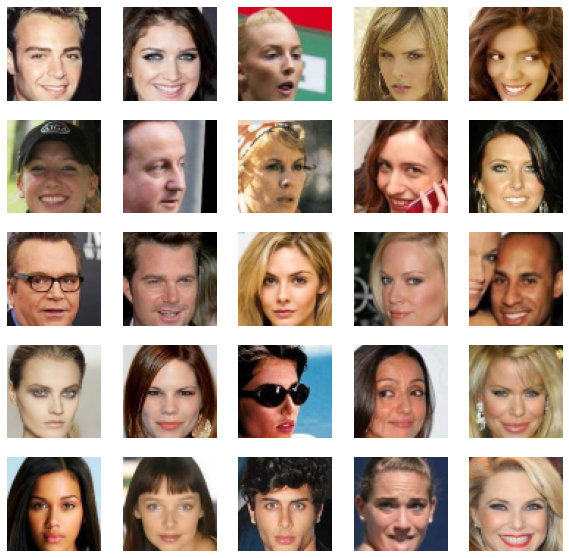

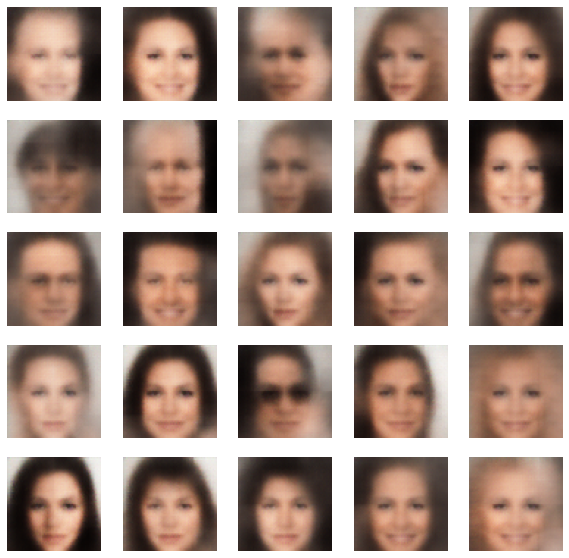

In [126]:
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    
show_batch(imgs1)
show_batch(prediction1)
    